# 04. Pytorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets

## Domain libraries

Depending on what you're looking on, vision, text, audio, recommendation, you'll want to look each of the PyTorch domain libreries for existing data loading functions and customizable data loading functions

**Resources:**
* Book version of the course materials for 04 https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version fo notebook 04

## 0 Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

# Note: Pytorch 1.10.0 + is required for this course
torch.__version__

'2.5.1+cu124'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Mon Feb 10 05:41:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1 Get some data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do ths?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.



In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exst... skipping download")
else:
  print(f"{image_path} directory doesn't  exst... creating one")
  image_path.mkdir(parents=True,
                   exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak and sushi
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unziping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't  exst... creating one
Unziping pizza, steak and sushi data...


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi' .
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test' .
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza' .
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak' .
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi' .
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train' .
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza' .
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak' .
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi' .


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some come to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working in images, let's open the image with Python's PIL
5. We'll then show the image and print the metadata

data/pizza_steak_sushi/train/steak/1761285.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/1761285.jpg
Image class: steak
Image height: 384
Image width: 512


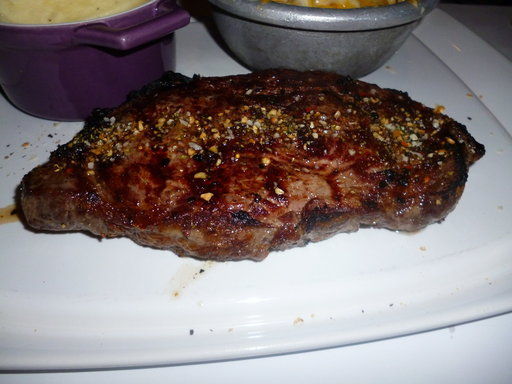

In [ ]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list= list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

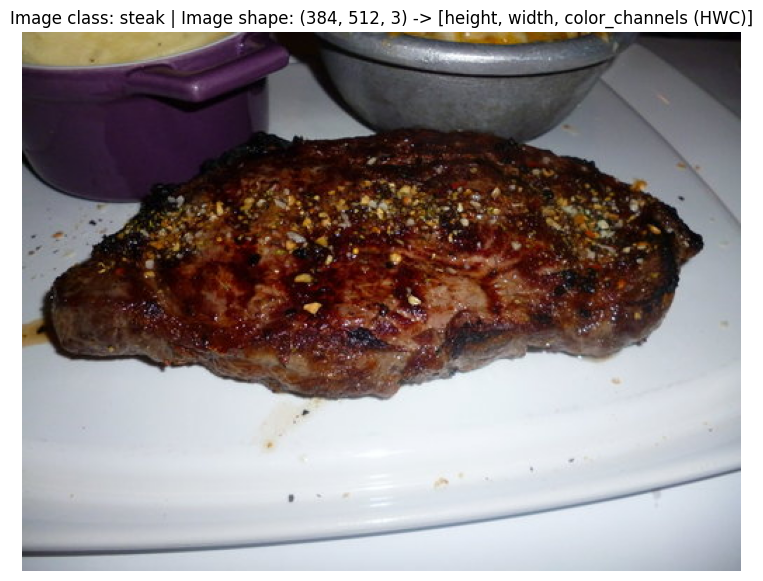

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels (HWC)]")
plt.axis(False)

## 3 Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensor (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `Dataloader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to used with a model/perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64,64)),
  # Fllp the images randomly on the horizonatal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.6118, 0.6275, 0.6706,  ..., 0.0392, 0.0353, 0.0235],
         [0.6157, 0.6275, 0.6627,  ..., 0.1333, 0.1216, 0.1098],
         [0.5804, 0.6314, 0.6667,  ..., 0.1608, 0.1490, 0.1373],
         ...,
         [0.3765, 0.3961, 0.4157,  ..., 0.6863, 0.6588, 0.6353],
         [0.4588, 0.4863, 0.5059,  ..., 0.6588, 0.6353, 0.6078],
         [0.5843, 0.6039, 0.6235,  ..., 0.6353, 0.6118, 0.5843]],

        [[0.5569, 0.5686, 0.6118,  ..., 0.0392, 0.0275, 0.0157],
         [0.5725, 0.5725, 0.6039,  ..., 0.1216, 0.1098, 0.1020],
         [0.5373, 0.5843, 0.6118,  ..., 0.1451, 0.1333, 0.1294],
         ...,
         [0.3843, 0.4039, 0.4196,  ..., 0.7098, 0.6902, 0.6706],
         [0.4824, 0.5020, 0.5333,  ..., 0.6863, 0.6667, 0.6431],
         [0.6078, 0.6314, 0.6549,  ..., 0.6667, 0.6431, 0.6157]],

        [[0.3608, 0.3490, 0.3922,  ..., 0.0431, 0.0314, 0.0314],
         [0.3765, 0.3569, 0.3804,  ..., 0.1294, 0.1176, 0.1020],
         [0.3529, 0.3804, 0.4039,  ..., 0.1647, 0.1490, 0.

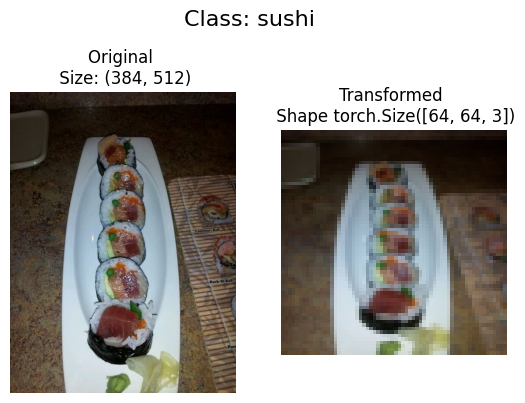

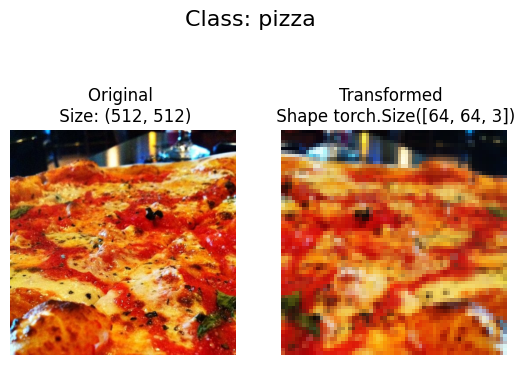

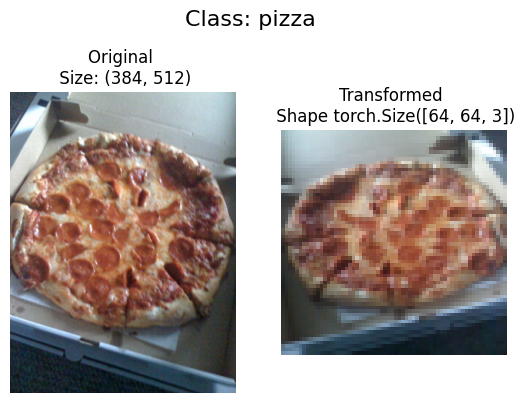

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      # Transform and plot target iamge
      transformed_image = transform(f).permute(1, 2, 0) # note: we'll need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4 Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # a transform for the label/target


test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lenghts of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.targets[0]

0

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

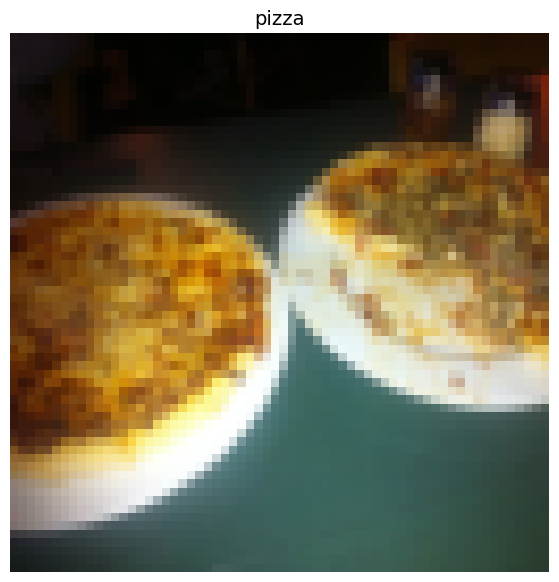

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoaders's`

A `DataLoader` is going to help us turn on `Dataset's` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time. In other case, we hardware gonna be out memory

In [ ]:
!nvidia-smi

Mon Feb 10 05:41:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Well count the number of cpu's available
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-build `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean, that it'll work...
* Using a custon  `Dataset` often results in us writting more code, which could be prone to errors or performance issues

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instace of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standar image classification format).
2. Raise and error if te class names aren't found (if this happend, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory.
  """

  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary of index labels (computers prefer number rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transformer if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mappeed to integer labels

## 6 Other forms of transforms (data augmentation)

Data augmentation is the process of artificial adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This pracice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [ ]:
# Let's look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg')]

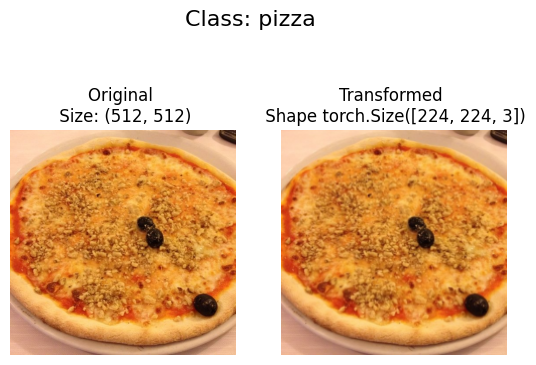

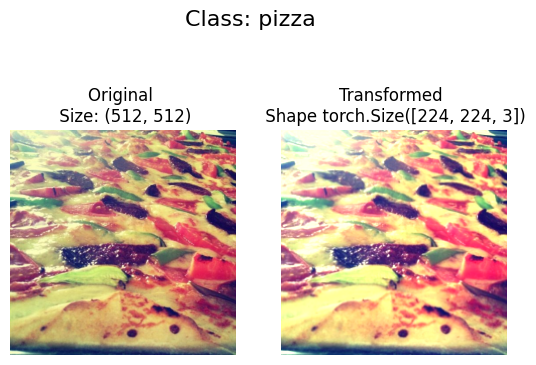

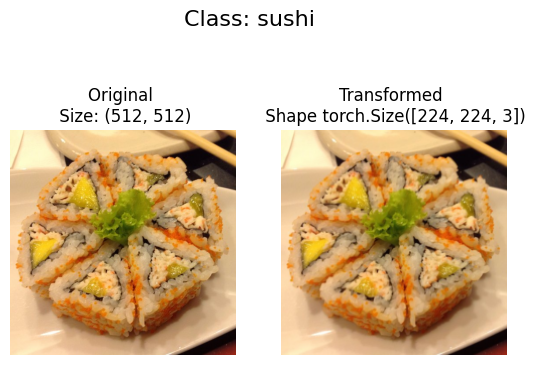

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7 Model 0: TinyVGG without data augmententation

Let's replicate TinyVGG architecture from the CNN explainer website

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN explainer
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) ->  None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) benefits from operator fusion

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop function

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
# Create train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup the train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output models logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimize the step step step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test_loss and test_acc values
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader
    for batch, (X,y) in enumerate(dataloader):
      # Send data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      #  Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### 7.6 Creating a `train()` function to combinate `train_step` y `test_step`

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train fuction that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create a empty results dictionary, this will help us to track our results
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss {test_loss:.4f} | Test acc {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(train_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our targetimages
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss 1.0983 | Test acc 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss 1.0697 | Test acc 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss 1.0809 | Test acc 0.4924
Epoch: 3 | Train loss: 1.0846 | Train acc: 0.3984 | Test loss 1.0606 | Test acc 0.5729
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4219 | Test loss 1.0657 | Test acc 0.5644
Total training time: 12.735 seconds


### 7.8 Plot the loss curve of Model 0

A **loss curve** is a way of tracking your model's progress over time

In [ ]:
# Get the model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results dictinonary
  """
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

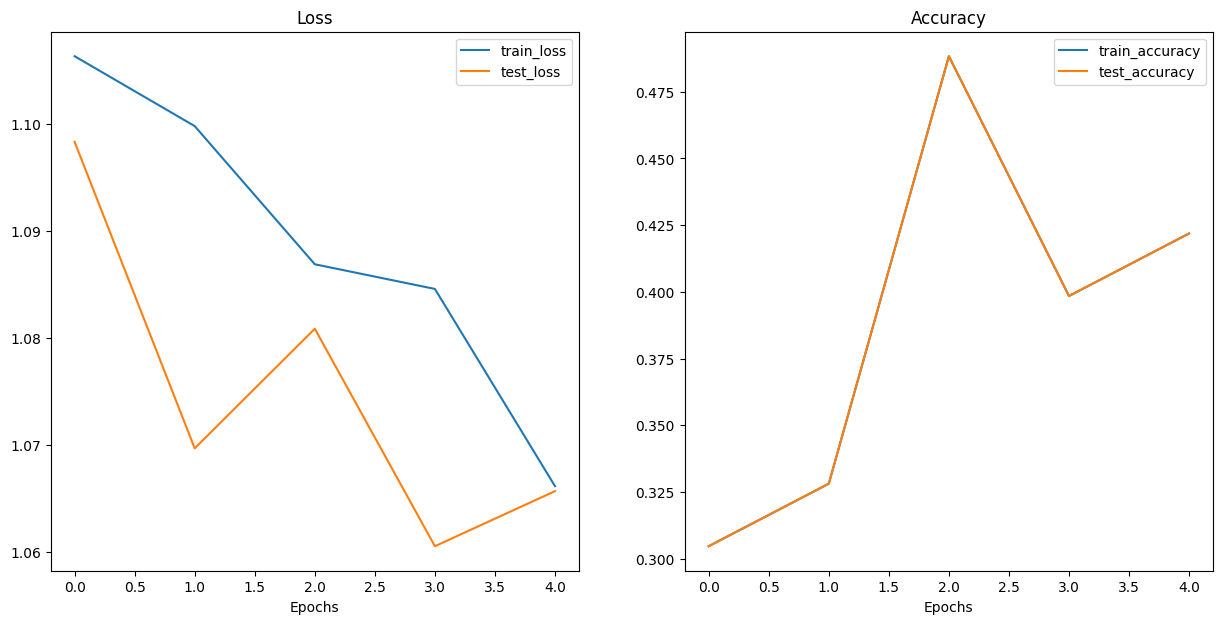

In [ ]:
plot_loss_curves(model_0_results)

## 8 What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

* Underfitting: When the curve could be lower
* Overfitting: Train lower than test. Your training is memorizing patterns that don't generalize in the test set
* Just right: Train and test loss similar

## 9 Model 1: TinyVGG with Data Augmenation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create a transform with data augmentaton

In [ ]:
# Create training transform with TriviailAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                            transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `Dataloaders`'s with data augmentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# turn on Datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [ ]:
# Create model 1 and send it to the target device

torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss 1.1019 | Test acc 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss 1.1261 | Test acc 0.2604
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss 1.1592 | Test acc 0.2604
Epoch: 3 | Train loss: 1.1254 | Train acc: 0.3047 | Test loss 1.1581 | Test acc 0.2604
Epoch: 4 | Train loss: 1.0859 | Train acc: 0.4258 | Test loss 1.1551 | Test acc 0.3333
Total training time for model_1: 16.467 seconds


### 9.4 Plot the loss curve of model 1

A loss curve helps you evaluate your models performance overtime

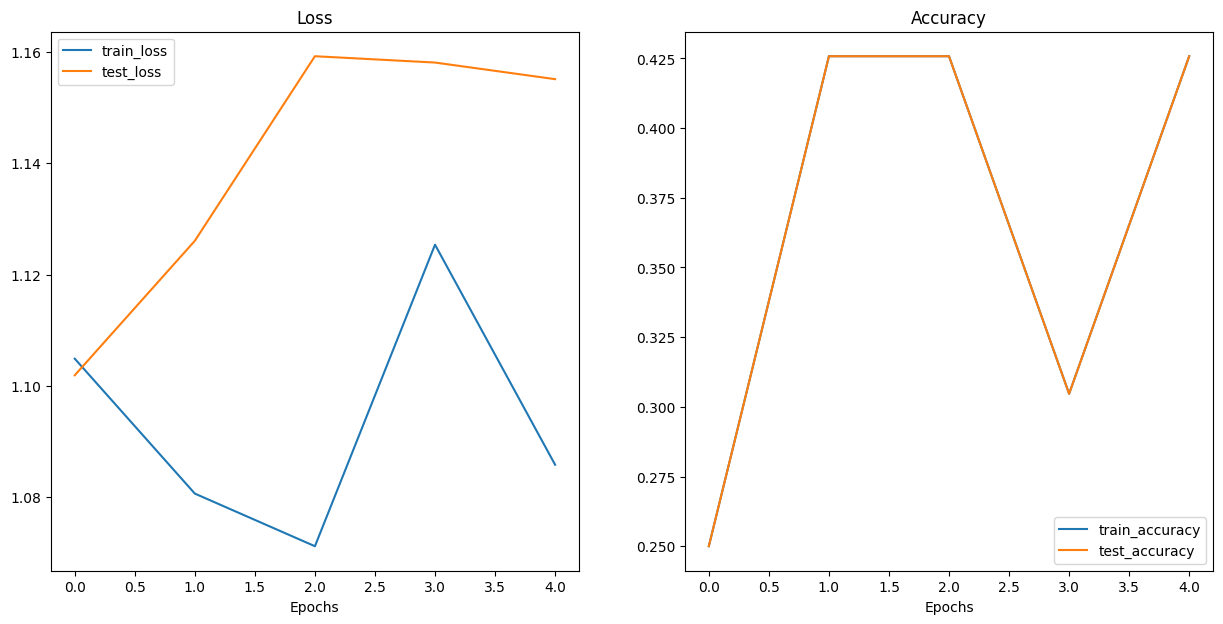

In [ ]:
plot_loss_curves(model_1_results)

## 10 Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a fwe different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
3. Weights and biases (to run different experiments) - https://wandb.ai/site/
4. MLflow - https://mlflow.org/

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106320,0.304688,1.098320,0.304688
1,1.099793,0.328125,1.069700,0.328125
2,1.086891,0.488281,1.080868,0.488281
3,1.084586,0.398438,1.060558,0.398438
4,1.066167,0.421875,1.065701,0.421875


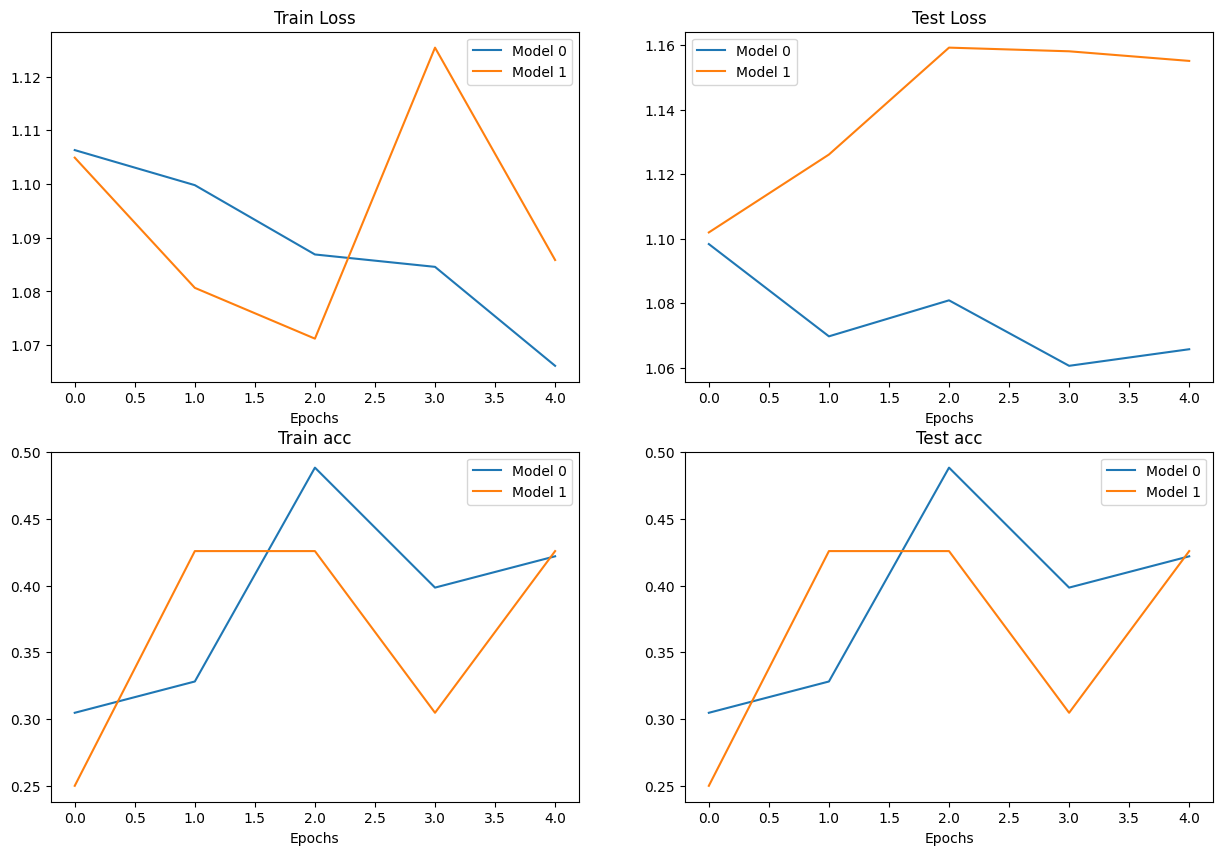

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

## 11 Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from Github we need the raw link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [ ]:
import torchvision

# Read and custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: \n {custom_image_uint8.shape}")
print(f"Custom image datatype: \n {custom_image_uint8.dtype}")

Custom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: 
 torch.Size([3, 4032, 3024])
Custom image d

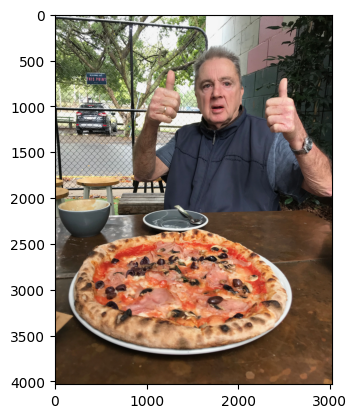

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained pytorch model

In [ ]:
# Try make a prediction on an image in unit8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# transform a target image
custom_image_transformed = custom_image_transform(custom_image)

custom_image_transformed.shape

torch.Size([3, 64, 64])

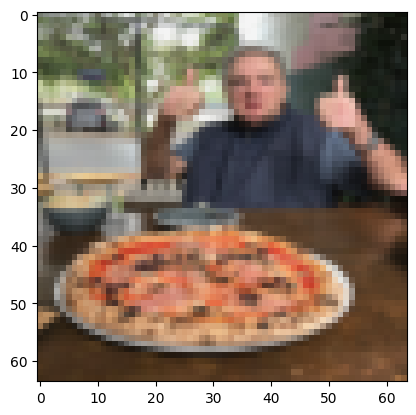

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
# Not batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [ ]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# Not batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0793,  0.0364, -0.2081]], device='cuda:0')

Note, to make a prediction on a custom image we had to:
* Load the image and turn in into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (64x64x3) with a batch size... (1,3,64,64)
* Make sure the image was in the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3692, 0.3537, 0.2770]], device='cuda:0')

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: Building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """
  Make a prediction on a target image with a trained model and plots the image and prediction.
  """
  # Load in the image
  target_image = torchvision.io.read_image(image_path).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0,1]
  target_image = target_image / 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of lx image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device))

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_labels} | Prob {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

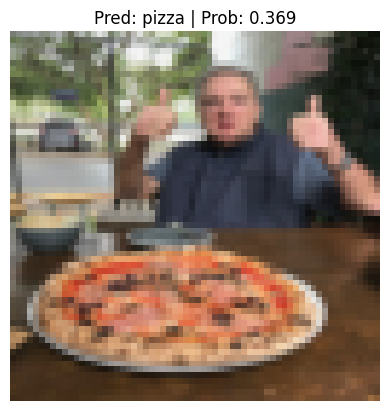

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)